## Unsupervised Algos Machine Learning

### Project Topic

For my final project I trained a weather perdiction system using [Weather Type Classification](https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data) dataset provided by kaggle. The unsupervised algorithm that I decied to use was a KMeans algorithm.

### 1. Import necessary Python libraries


In [80]:
import os
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

### 2. Helper Functions

The following function loads a dataset from a CSV file by dynamically constructing the file path using the current working directory and a designated subdirectory named "dataset". It then uses pandas’ CSV reader to load the file’s contents into a DataFrame.

In [81]:
def load_data(file_name:str) -> pd.DataFrame:
    full_path = os.path.join(os.getcwd(), f"dataset/{file_name}")
    data = pd.read_csv(full_path)
    return data

The following function provide an inital overview of the dataset by displaing its structure, summary, statistics and preview of the first few records.

In [82]:
def data_info(data:pd.DataFrame):
    print(f"Dataset Size: {data.shape}\n")

    print("First 5 rows of dataset:")
    display(data.head())
    
    print("Summary of dataset:")
    display(data.describe())
    
    print("Sum of null values in dataset:")
    display(data.isnull().sum())

    print("Dataset info:")
    data.info()

The following function encodes categorical data before calculating and ploting the variance for the dataset columns.

In [83]:
def get_variance(data:pd.DataFrame):
    le = LabelEncoder()
    data["weather_type_encoded"] = le.fit_transform(data["Weather Type"])
    data_encoded = pd.get_dummies(data, columns=["Season", "Location", "Cloud Cover"], drop_first=True)
    data_encoded.drop(columns=["Weather Type"], inplace=True)
    var_series = data_encoded.var().sort_values()
    display(var_series)
    var_dict = var_series.to_dict()
    plt.figure(figsize=(10, 6))
    plt.bar(var_dict.keys(), var_dict.values())
    plt.xticks(rotation=45)
    plt.show()

The follwoing function does some data cleaning by dropping columns in the passed cols_to_drop list.

In [84]:
def clean_data(data:pd.DataFrame, cols_to_drop:list) -> pd.DataFrame:
    cleaned_data = data.drop(columns=cols_to_drop)
    return cleaned_data

The following function plots the histograms of the features in the dataset.

In [85]:
def feature_hist(data:pd.DataFrame):
    data_temp = data.drop(columns=["weather_type_encoded"])
    data_temp.hist(figsize=(12, 8), bins=15, edgecolor="black")
    plt.show()

The following function calculates the correlation matrix of the dataset and plots and sns heatmap of the correlation matrix.

In [86]:
def get_corr(data:pd.DataFrame):
    cleaned_data = data.drop(columns="Weather Type")
    corr_matrix = cleaned_data.corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt="0.2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

The following functions is a modified version of the label_permute_compare() function from [Week 2: Clustering Lab](https://hub.labs.coursera.org:443/connect/sharedzoazeddu?forceRefresh=false&path=%2Fnotebooks%2FModule2_USL.ipynb&isLabVersioning=true) it used to calculate the best accuracy from the best premutaion.

In [87]:
def label_permute_compare(ytdf,yp, weather_type, n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    pd.set_option('future.no_silent_downcasting', True)
    perms = list(itertools.permutations(range(0, n), n))

    best_premutation = []
    best_accuracy = 0

    for perm in perms:
        mapping = {}
        for i in range(len(perm)):
            mapping[weather_type[i]] = perm[i]

        y_true = pd.DataFrame(ytdf["Weather Type"]).replace(mapping).infer_objects(copy=False)

        curr_acc = accuracy_score(y_true, yp)
        if curr_acc > best_accuracy:
            best_accuracy = curr_acc
            best_premutation = perm 

    return best_premutation, best_accuracy

### 2. Load Data and Exploratory Data Analysis (EDA)

Load weather data by calling the load_data() function with the weather data filename. Then perfrom the inital data analysis by calling data_info() function. The data_info() function will print the out the data size, the first 5 rows in  the data set, a summary of some data metrics/statistics, check for any null values in the dataset, and finally display the dataset column info.

In [88]:
weather_data = load_data("weather_classification_data.csv")
data_info(weather_data)

Dataset Size: (13200, 11)

First 5 rows of dataset:


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Summary of dataset:


,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


Sum of null values in dataset:


Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


As part of the EDA call the get_variance() function that will display and plot the variance of every column in the dataset.

Cloud Cover_cloudy              0.030169
Season_Summer                   0.153159
Season_Spring                   0.158093
Cloud Cover_partly cloudy       0.226133
Location_mountain               0.231690
Location_inland                 0.231752
Season_Winter                   0.244394
Cloud Cover_overcast            0.248526
weather_type_encoded            1.250095
Visibility (km)                11.367005
UV Index                       14.873366
Wind Speed                     47.730193
Temperature                   302.284352
Humidity                      407.807656
Precipitation (%)            1020.581467
Atmospheric Pressure         1383.809399
dtype: float64

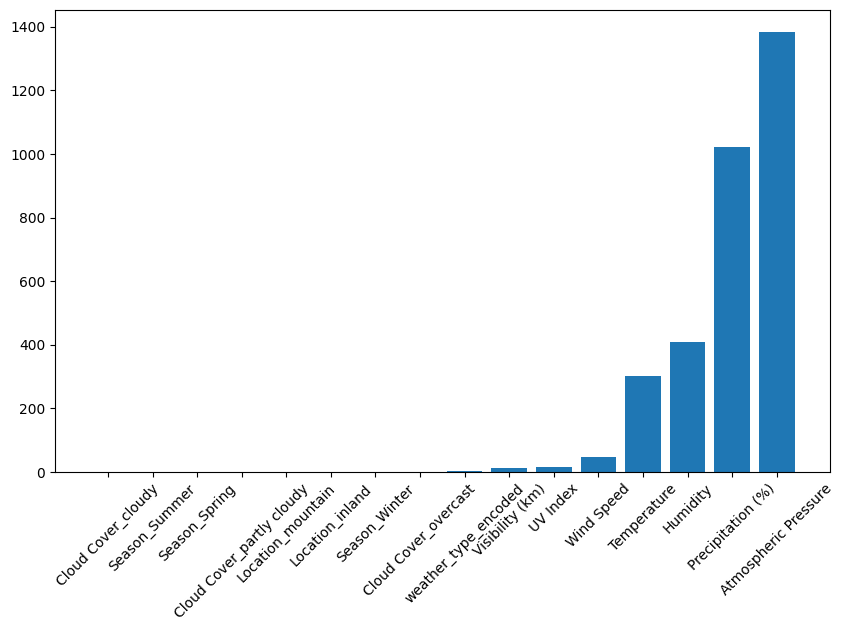

In [89]:
get_variance(weather_data)

### 3. Data Cleaning
Based off the plot and the displayed variances of the columns, the columns "Cloud Cover", "Season", and "Location" have the a near 0 variance and as result they should be dropped from the data set since not much perdicive power can be gained from them. This is achieved by creating a list of the columns that will be dropped and calling the clean_data() function. This will return a "cleaned" dataset.

In [90]:
cols_to_drop = ["Cloud Cover", "Season", "Location"]
cleaned_data = clean_data(weather_data, cols_to_drop)

Next call the feature_hist() function to plot the histograms of the remaining columns. 

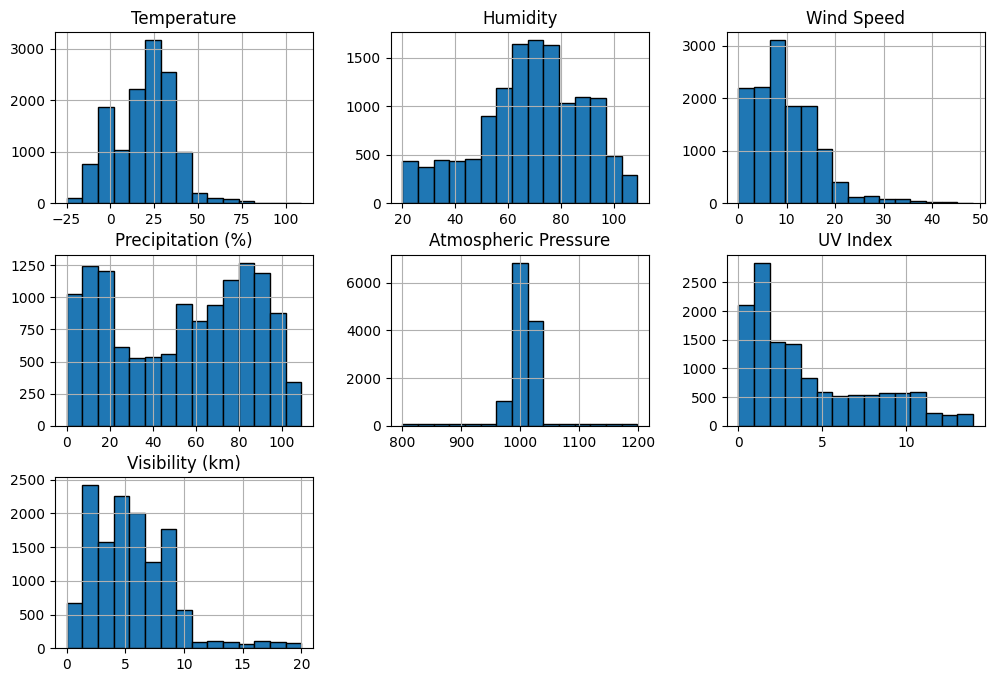

In [91]:
feature_hist(cleaned_data)

Next call get_corr() to get the corrlation of the current features in the dataset. 

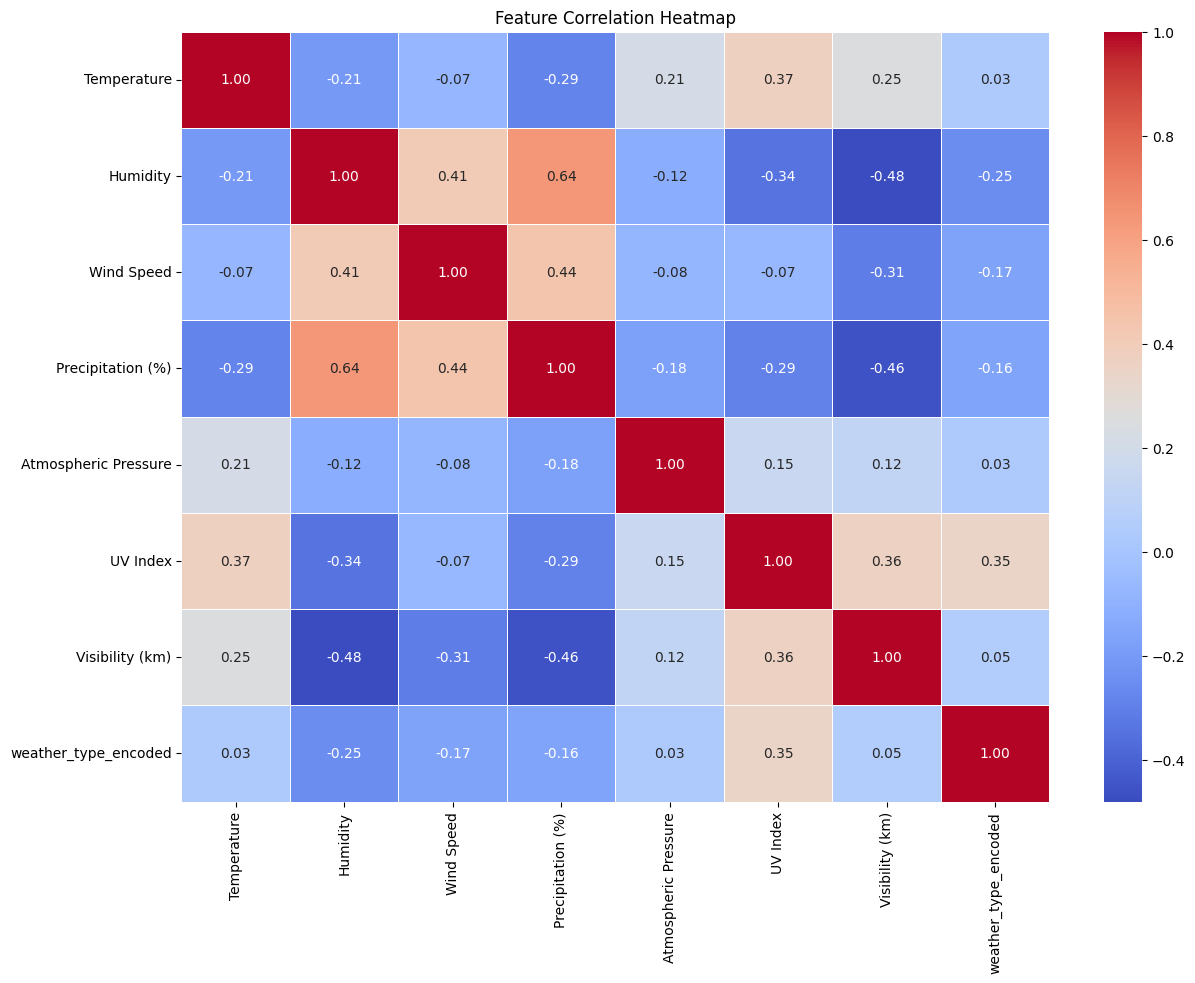

In [92]:
get_corr(cleaned_data)

Based off the histogram plots, the Atomspheric Pressure seems to skew towards around 1000 for majority of the values. As a result the Atmospheric pressure will also be dropped befroe training a model. Based off the correlation matrix plot Humidity and Precipitation (%) appear to be closely correlated, but shouldnt have an effect on the KMeans model since high precipitation (%) would lead to high humidity.

Next call get_corr() to get the corrlation of the current features in the dataset. 

In [93]:
cols_to_drop = ["Atmospheric Pressure"]
cleaned_data = clean_data(cleaned_data, cols_to_drop)

### 4. Model Training

To being training a model first the columns that will be used as features will be selected. Next initialize a scaler object to scale the selected features. The scaling is need to increase the perfromacne and convergance speed of models such as KMeans.

In [94]:
features = ["Temperature", "Humidity", "Wind Speed", "Precipitation (%)", "UV Index", "Visibility (km)"]

x = cleaned_data[features]
y = cleaned_data["Weather Type"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

Next create a KMeans object with n_clusters set to 4 since there are 4 unique weather types and random_state set to an integer to have reproducible results. The call fit_predict() with the x_scaled data to compute the clusters and predict the clust indices.

In [95]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(x_scaled)


Next calculate the accuarcy of the model using the modified label_permute_compare() function, the function will return the best label order and accuarcy from all possible premuations. The best accuary was about 64.87% which means the model is a good fit and will be able to accuratly predict the weather for about 27% of the time. In order to imporve some tuning will be needed.

In [96]:
weather_types = list(cleaned_data["Weather Type"].unique())

label_order, acc = label_permute_compare(cleaned_data, clusters, weather_types, n=len(weather_types))

print(label_order, acc)

(2, 3, 0, 1) 0.6487121212121212


### 5. Model Tuning

Since the inital model's accuracy only resulted in an accuracy of 64.87 percent. Some tuning will be preformed in an attempt to train a model with a higher accuarcy. For the KMeans tuning a range of 2 - 20 that iterate through the range and train a KMeans model with that specific n_clusters and then computes the label order and accuracy. After iterating thorugh the range a plot of the n_clusters vs the accuracy of the model.

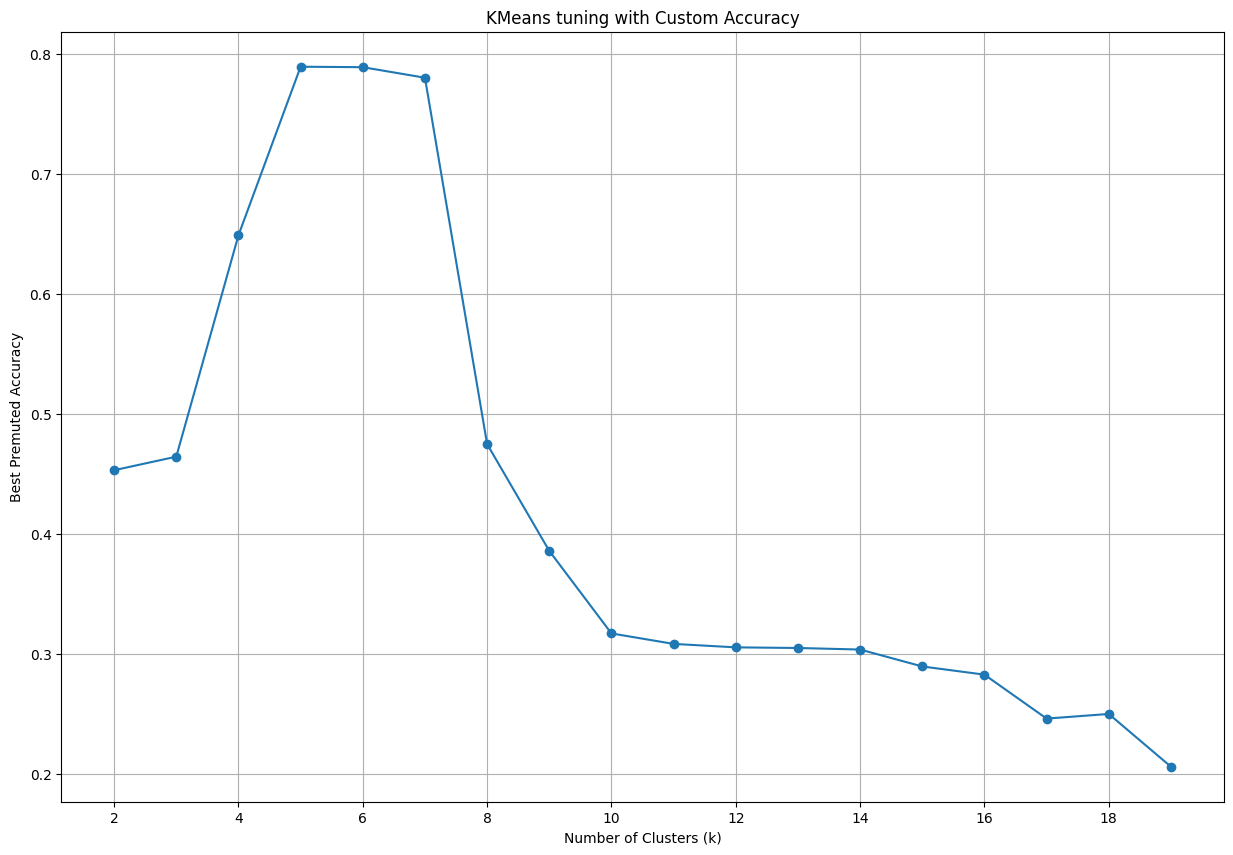

Best n_cluster: 5
Best Accuracy: 0.7890909090909091
Best Lable Order: (2, 3, 0, 1)


In [97]:
k_values = range(2, 20)

acc_scores = []
best_acc = 0
best_label_order = None
best_n_cluster = None

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(x_scaled)


    label_order, acc = label_permute_compare(cleaned_data, clusters, weather_types, n=len(weather_types))

    acc_scores.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_label_order = label_order
        best_n_cluster = k

plt.figure(figsize=(15, 10))
plt.plot(k_values, acc_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Best Premuted Accuracy")
plt.title("KMeans tuning with Custom Accuracy")
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

print(f"Best n_cluster: {best_n_cluster}")
print(f"Best Accuracy: {best_acc}")
print(f"Best Lable Order: {best_label_order}")

### 6 Results and Analysis

Bassed off the plot the best n_clusters for the KMeans model are 5-7, with 5 being the best with an accuracy of approximately 78.90%. While increasing the n_clusters past 7 only decreased the accuracy. The tuning did wrork in training a model with an increased accuracy, however this is still a low accuracy. I would have liked to have trained a model that could achieve at least 90% accuracy. 

### 7 Conclusion

Overall a KMeans model for the Weather Type Classification dataset was a good pick. Some keytake aways from this project show how the number of n_clusters affects the accuracy of a KMeans model and that with some tuning a models accuracy can be increased significantly. If I had more time I would have liked to try other unsupervised machine learning algorithms, such as Principal Component Analysis (PCA), Support Vector Machine (SVM), or Hierarchial Clustering and see how well they perfom on this dataset.

### Refrences

1. [Weather Type Classification Data](https://www.kaggle.com/datasets/nikhil7280/weather-type-classification)
2. [SKlearn Preprocessing Data Docs](https://scikit-learn.org/stable/modules/preprocessing.html)
3. [Sklearn KMeans Docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
4. [KMeans Hyper-parameters Explained](https://medium.com/data-science/kmeans-hyper-parameters-explained-with-examples-c93505820cd3)
5. [Week 2: Clustering Lab](https://hub.labs.coursera.org:443/connect/sharedzoazeddu?forceRefresh=false&path=%2Fnotebooks%2FModule2_USL.ipynb&isLabVersioning=true)

### Github Repo Link

https://github.com/charliearvizu-edu/CSCA_5632_PROJ/tree/dev